In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib ipympl

from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.ode import solve_system
from neurodiffeq.networks import FCNN
from neurodiffeq.networks import SinActv # sin activation
import torch.nn as nn

In [3]:
# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda u, v, t : [ diff(u, t) - (alpha*u  - beta*u*v),
                                    diff(v, t) - (delta*u*v - gamma*v), ]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, u_0=1.5),  # 1.5 is the value of u at t_0 = 0.0
    IVP(t_0=0.0, u_0=1.0),  # 1.0 is the value of v at t_0 = 0.0
]

# specify the network to be used to approximate each dependent variable
# the input units and output units default to 1 for FCNN
nets_lv = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12,
    nets=nets_lv, max_epochs=3000
)

/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/neurodiffeq/ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

In [6]:
beta, gamma, population = 0.5, 0.1, 1000

def SIR(S, I, R, t):
    x1 = diff(S, t) - (-beta * S * I / population)
    x2 = diff(I, t) - (beta * S * I / population - gamma * I)
    x3 = diff(R, t) - gamma * I
    return [x1, x2, x3]

init_vals = [IVP(t_0=0.0, u_0=999.0), IVP(t_0=0.0, u_0=1.0), IVP(t_0=0.0, u_0=0.0)]

nets_sir = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32)),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32)),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32))
]

# solution_sir, _ = solve_system(
#     ode_system=SIR, conditions=init_vals, t_min=0.0, t_max=100,
#     nets=nets_lv, max_epochs=3000,
#     monitor=Monitor1D(t_min=0.0, t_max=100, check_every=100)
# )

Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/neurodiffeq/_version_utils.py:47: FutureWarning: The argument `as_type` is deprecated for __call__; use `to_numpy` instead.
  warnings.warn(f'The argument `{alias}` is deprecated for {func_name}; use `{new}` instead.', FutureWarning)


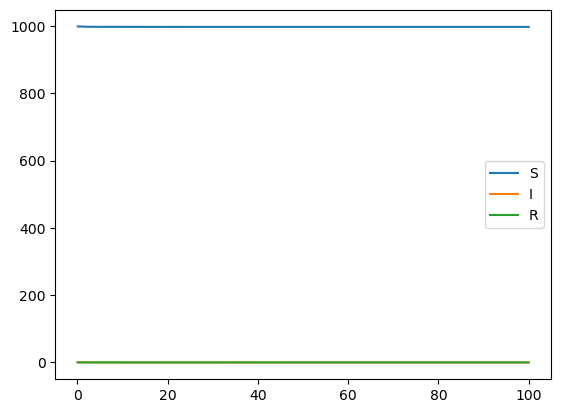

In [9]:

from neurodiffeq.solvers import Solver1D

# # Let's create a monitor first
# monitor = Monitor1D(t_min=0.0, t_max=100, check_every=100)
# # ... and turn it into a Callback instance
# monitor_callback = monitor.to_callback()

# Instantiate a solver instance
solver = Solver1D(
    ode_system=SIR,
    conditions=init_vals,
    t_min=0,
    t_max=100,
    nets=nets_sir,
)

# Fit the solver (i.e., train the neural networks)
solver.fit(max_epochs=3000)# , callbacks=[monitor_callback])

# Get the solution
solution_sir = solver.get_solution()

# Plot the solution
t = np.linspace(0.1, 100, 1000)
S, I, R = solution_sir(t, as_type='np')
plt.plot(t, S, label='S')
plt.plot(t, I, label='I')
plt.plot(t, R, label='R')
plt.legend()
plt.show()

Text(0.5, 1.0, 'S')

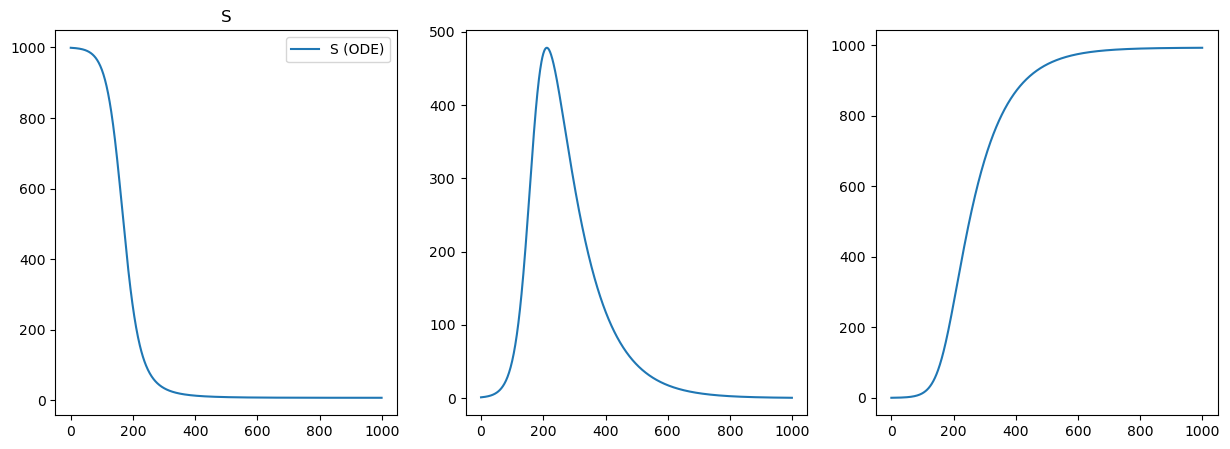

In [5]:
from scipy.integrate import odeint

def dPdt(P, t):
    return [
        -beta * P[0] * P[1] / population,
        beta * P[0] * P[1] / population - gamma * P[1],
        gamma * P[1]
    ]

t = np.linspace(0, 100, 1000)
P0 = [999, 1, 0]
P = odeint(dPdt, P0, t)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#ax[0].plot(solution_sir(t).detach().numpy()[:, 0], label='S (ANN)')
ax[0].plot(P[:, 0], label='S (ODE)')
ax[1].plot(P[:, 1], label='I (ODE)')
ax[2].plot(P[:, 2], label='R (ODE)')    
ax[0].legend()
ax[0].set_title('S')
